<a href="https://colab.research.google.com/github/HanifRafandi014/3D_Machine_Learning/blob/main/ML_Pertemuan-10(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Hanif Naufal Rafandi

Kelas : 3D / 14

NIM : 2141720127

Machine Learning Jobsheet 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. **Import Library**

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

# **Praktikum 1 RNN untuk Analisis Sentimen**




2. **Buat fungsi pembantu untuk memplot grafik**

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

3. **Setup input pipeline**

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# Awalnya ini mengembalikan dataset (teks, pasangan label):
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
# Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'In light of the recent and quite good Batman the Brave and the Bold, now is the time to bear a fatal blow to that mistake in the life of Batman. Being a huge fan since the first revival by Tim Burton 20 years ago, I have been able to accept different tonalities in the character, dark or campy. This one is just not credible : too many effects, poor intrigues and so few questions. What is great about Batman is the diversity of his skills and aspects of his personality : detective, crime-fighter, playboy, philanthropist etc. The Batman shows him only in his karate days. And by the way, how come the Penguin is capable of such virtuosity when jumping in the air regardless of his portly corpulence ? And look at the Joker, a mixture of Blanka in Street Fighter 2 and a stereotypical reggae man, what Batman fan could accept such a treason ? Not me anyway. Batman is much better without "The" article in front of his name.'
 b'Since Douglas MacArthur affected more human lives\xc2\x97for

4. **Buat Teks Encoder**

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  8, 705,   5, ...,   0,   0,   0],
       [231,   1,   1, ...,   0,   0,   0],
       [107,   4, 331, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'In light of the recent and quite good Batman the Brave and the Bold, now is the time to bear a fatal blow to that mistake in the life of Batman. Being a huge fan since the first revival by Tim Burton 20 years ago, I have been able to accept different tonalities in the character, dark or campy. This one is just not credible : too many effects, poor intrigues and so few questions. What is great about Batman is the diversity of his skills and aspects of his personality : detective, crime-fighter, playboy, philanthropist etc. The Batman shows him only in his karate days. And by the way, how come the Penguin is capable of such virtuosity when jumping in the air regardless of his portly corpulence ? And look at the Joker, a mixture of Blanka in Street Fighter 2 and a stereotypical reggae man, what Batman fan could accept such a treason ? Not me anyway. Batman is much better without "The" article in front of his name.'
Round-trip:  in light of the [UNK] and quite good [UNK] the [

5. **Buat Model**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.01033377]


In [ ]:
# predict on a sample text with padding
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 363ms/step
[0.01033378]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

6. **Train Model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 710s 2s/step - loss: 0.6603 - accuracy: 0.5450 - val_loss: 0.5119 - val_accuracy: 0.7542
Epoch 2/10
391/391 [==============================] - 699s 2s/step - loss: 0.4323 - accuracy: 0.7949 - val_loss: 0.3930 - val_accuracy: 0.8281
Epoch 3/10
391/391 [==============================] - 704s 2s/step - loss: 0.3601 - accuracy: 0.8427 - val_loss: 0.3603 - val_accuracy: 0.8521
Epoch 4/10
391/391 [==============================] - 692s 2s/step - loss: 0.3352 - accuracy: 0.8536 - val_loss: 0.3433 - val_accuracy: 0.8589
Epoch 5/10
391/391 [==============================] - 705s 2s/step - loss: 0.3164 - accuracy: 0.8643 - val_loss: 0.3263 - val_accuracy: 0.8594
Epoch 6/10
391/391 [==============================] - 698s 2s/step - loss: 0.3095 - accuracy: 0.8690 - val_loss: 0.3323 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 687s 2s/step - loss: 0.3064 - accuracy: 0.8703 - val_loss: 0.3270 - val_accuracy: 0.8526

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 170s 436ms/step - loss: 0.3180 - accuracy: 0.8606
Test Loss: 0.3180450201034546
Test Accuracy: 0.8605999946594238


(0.0, 0.6784724205732345)

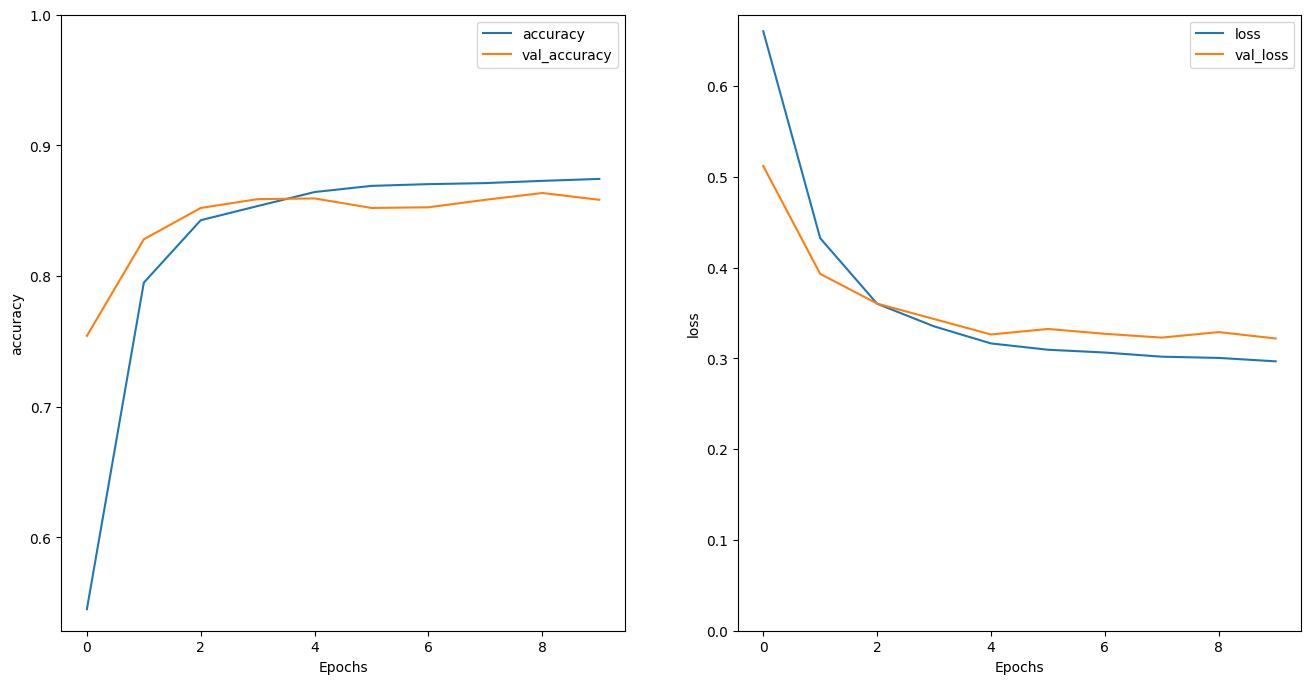

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


7. **Stack two or more LSTM layers**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1428s 4s/step - loss: 0.6454 - accuracy: 0.5614 - val_loss: 0.4531 - val_accuracy: 0.7953
Epoch 2/10
391/391 [==============================] - 1400s 4s/step - loss: 0.3973 - accuracy: 0.8205 - val_loss: 0.3518 - val_accuracy: 0.8401
Epoch 3/10
391/391 [==============================] - 1406s 4s/step - loss: 0.3372 - accuracy: 0.8533 - val_loss: 0.3322 - val_accuracy: 0.8594
Epoch 4/10
391/391 [==============================] - 1421s 4s/step - loss: 0.3190 - accuracy: 0.8634 - val_loss: 0.3421 - val_accuracy: 0.8615
Epoch 5/10
391/391 [==============================] - 1395s 4s/step - loss: 0.3137 - accuracy: 0.8654 - val_loss: 0.3450 - val_accuracy: 0.8349
Epoch 6/10
391/391 [==============================] - 1405s 4s/step - loss: 0.3090 - accuracy: 0.8665 - val_loss: 0.3331 - val_accuracy: 0.8349
Epoch 7/10
391/391 [==============================] - 1413s 4s/step - loss: 0.3059 - accuracy: 0.8698 - val_loss: 0.3234 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 301s 771ms/step - loss: 0.3240 - accuracy: 0.8604
Test Loss: 0.32397857308387756
Test Accuracy: 0.8604400157928467


In [ ]:
# predict on a sample text without padding.
sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 7s 7s/step
[[-1.8632307]]


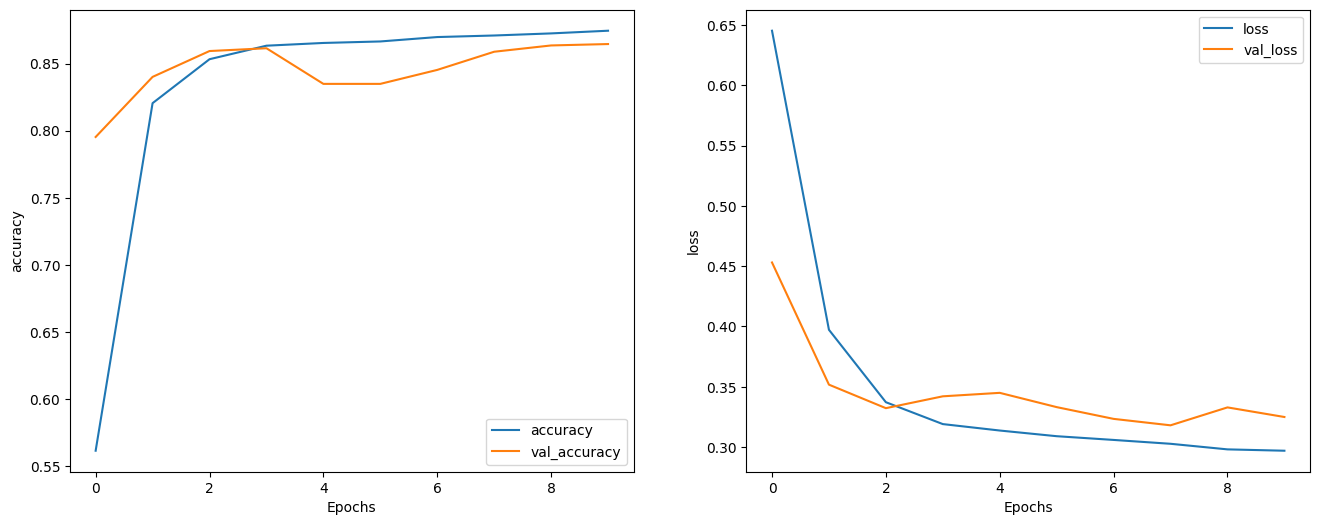

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# **Praktikum 2 Generator Teks dengan RNN**

QUEENE:
I had thought thou hadst a Roman; for the oracle,
Thus by All bids the man against the word,
Which are so weak of care, by old care done;
Your children were in your holy love,
And the precipitation through the bleeding throne.

BISHOP OF ELY:
Marry, and will, my lord, to weep in such a one were prettiest;
Yet now I was adopted heir
Of the world's lamentable day,
To watch the next way with his father with his face?

ESCALUS:
The cause why then we are all resolved more sons.

VOLUMNIA:
O, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, it is no sin it should be dead,
And love and pale as any will to that word.

QUEEN ELIZABETH:
But how long have I heard the soul for this world,
And show his hands of life be proved to stand.

PETRUCHIO:
I say he look'd on, if I must be content
To stay him from the fatal of our country's bliss.
His lordship pluck'd from this sentence then for prey,
And then let us twain, being the moon,
were she such a case as fills m

1. **Import TensorFlow**

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

2. **Download Dataset Shakespeare**

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


3. **Load Data**

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**Olah Teks**

**Vectorize Teks**

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary = ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

**Prediksi**

**Membuat Traning Set dan Target**

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


**Membuat Batch Training**

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

**Buat Model**

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

**Uji Model**

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([14, 65, 54, 59, 43,  5, 10, 48,  8, 26, 31, 34, 54, 47, 32, 57, 22,
       28, 15, 29,  5, 39, 47, 45, 15,  7,  1, 34,  8, 62, 15, 46, 15, 43,
       54, 26, 32, 64, 40, 64,  3,  0, 19, 58, 17, 46, 19, 42, 46, 63, 56,
       35, 50, 36, 45, 57, 52, 57, 33, 62, 38, 63, 62, 26, 28,  9, 18, 40,
       29, 59,  8,  2, 45,  1, 12, 47,  3, 46,  0, 14, 14, 24, 15, 58, 64,
        8, 48, 55, 13, 30, 36, 18,  5, 22, 63, 32, 55, 39, 11,  0])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'.\nAnd is Aufidius with him? You are they\nThat made the air unwholesome, when you cast\nYour stinking '

Next Char Predictions:
 b'Azotd&3i-MRUohSrIOBP&ZhfB,\nU-wBgBdoMSyay![UNK]FsDgFcgxqVkWfrmrTwYxwMO.EaPt- f\n;h!g[UNK]AAKBsy-ip?QWE&IxSpZ:[UNK]'


**Train Model**

**Tambahan optimizer dan fungsi loss**

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.189996, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.022514

In [ ]:
model.compile(optimizer='adam', loss=loss)

**Konfigurasi Checkpoints**

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

**Lakukan Proses Training**

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 898s 5s/step - loss: 2.7193
Epoch 2/20
172/172 [==============================] - 870s 5s/step - loss: 1.9888
Epoch 3/20
172/172 [==============================] - 870s 5s/step - loss: 1.7108
Epoch 4/20
172/172 [==============================] - 889s 5s/step - loss: 1.5477
Epoch 5/20
172/172 [==============================] - 887s 5s/step - loss: 1.4475
Epoch 6/20
172/172 [==============================] - 886s 5s/step - loss: 1.3789
Epoch 7/20
172/172 [==============================] - 877s 5s/step - loss: 1.3271
Epoch 8/20
172/172 [==============================] - 868s 5s/step - loss: 1.2825
Epoch 9/20
172/172 [==============================] - 858s 5s/step - loss: 1.2417
Epoch 10/20
172/172 [==============================] - 856s 5s/step - loss: 1.2022
Epoch 11/20
172/172 [==============================] - 850s 5s/step - loss: 1.1615
Epoch 12/20
172/172 [==============================] - 847s 5s/step - loss: 1.1204
Epoch 13/20
1

**Generate Teks**

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
The dangerous dangerous speeching blood;
O, but it is nor honour slain by law,
Proclaims in-cornations: which shall pardon thee,
That our solemnity and fair as made
Prief how thou sees' and arm the tyrant's ricers.

KING HENRY VI:
My Lord of Sobertislamation would have sworn
The portering of a friend,
Are he will show thy saddle curses.

KING RICHARD II:
What's the rather that, awaked, I would not
do you fetter. Duchison well seen absolution,
Do not image bereight to the highbour:--
By dishonour'd, would spend both their astemness
Is nothing like an hour. Live an Hortantior
Loved as you are come thence.

Messenger:
If it be wish, what hath that bare before I want work.

EXETER:
The sand and kind of Second Kate still, but would
Is law as you, she speaks not so bright,
Which to this sentence of my curging tyrann
To bod till Rome, and we can carriold
The glory of my tale tongue.

ESCALUS:
Ay, that is more appointed it.

MENENIUS:
I'll she know this base:
The rashly wrong'd him.

DU

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nWhence, I pray now, you shall grieve you now.\n\nLOHD SIRF DIO:\nWho often forbid myself!\n\nCLAUET:\nO he dischare that name, forbears!\nWhat man we must for you, sir abide is long.\nThe father is well approved all must, why,\nthen this is mine obsio, here entreat me.\n\nQUEEN ELIZABETH:\nHow fares I keep of crossfitt of.\n\nLUCENTIO:\nO present time, friends, mine is yours.\nYou promised me, that from the Lord Hastings\nOf Rome woe in thy tatcher'd rootest and Lord Stand,\nAnd full of venity boach with her excuse.\n\nRICHMOND:\nFlower with me, thou mightst kill thy eyes\nJegrens from the warding of my money, never march\nTo win her, let us by secret heart\nHath not the time from the holy crace;\nBut then in persuade he Should be;\nAnd therein well commanded to his head,\nNor executel to a man were cheeked from thee.\nI'll undertake thy fortune or\na young swift sims too reginent to thee,\nIf we have still still soundantly face, and\nmeant to scold. Then valiant 

**Ekspor Model Generator**

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
The very tricks of that the moPthook of art?

All:
Clartis, welcome!

AUFIDIUS:
Where is he?

CLIFF


# **Tugas Pertemuan 10**

Gunakan tf.GradientTape untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca eager execution guide.
Prosedurnya adalah "
1. Jalankan Model dan hitung loss dengan tf.GradientTape.
2. Hitung update dan terapkan pada model dengan optimizer

In [ ]:
class CustomTraining(MyModel):
     @tf.function
     def train_step(self, inputs):
        inputs, labels = inputs
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.loss(labels, predictions)
            grads = tape.gradient(loss, model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

            return {'loss': loss}

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 861s 5s/step - loss: 2.7403


In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.2026
Epoch 1 Batch 50 Loss 2.0802
Epoch 1 Batch 100 Loss 1.9874
Epoch 1 Batch 150 Loss 1.8771

Epoch 1 Loss: 2.0040
Time taken for 1 epoch 861.92 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8803
Epoch 2 Batch 50 Loss 1.7759
Epoch 2 Batch 100 Loss 1.7446
Epoch 2 Batch 150 Loss 1.6926

Epoch 2 Loss: 1.7200
Time taken for 1 epoch 840.04 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6129
Epoch 3 Batch 50 Loss 1.5191
Epoch 3 Batch 100 Loss 1.5911
Epoch 3 Batch 150 Loss 1.5313

Epoch 3 Loss: 1.5578
Time taken for 1 epoch 861.91 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.5391
Epoch 4 Batch 50 Loss 1.4892
Epoch 4 Batch 100 Loss 1.4622
Epoch 4 Batch 150 Loss 1.4338

Epoch 4 Loss: 1.4583
Time taken for 1 epoch 861.92 sec
_________________________________________________________________

## Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?

**Potongan Kode Praktikum 2 (Penggunaan Fungsionalitas Keras)**

1. Penggunaan Fungsionalitas Keras Terintegrasi: Potongan kode pada praktikum 2 menggunakan lebih banyak fungsionalitas bawaan dari TensorFlow/Keras.
2. Penggunaan Layer Keras: Model didefinisikan dengan menggunakan lapisan-lapisan Keras seperti Embedding, GRU, dan Dense. Ini membuat penggunaan model lebih mudah karena Keras mengelola sebagian besar operasi.
3. Training dengan Fungsi fit(): Model dilatih menggunakan metode fit() yang lebih terintegrasi dan menangani hampir semua aspek pelatihan.
4. Penggunaan Callbacks: Potongan kode ini juga menggunakan callbacks dalam proses pelatihan, khususnya ModelCheckpoint untuk menyimpan bobot model setelah setiap epoch.

**Potongan Kode Tugas (Model Custom)**

1. Model Custom: Potongan kode di Tugas membahas penggunaan model yang dibuat secara manual dengan pendekatan yang lebih langsung.
2. Pembuatan Model dan Pelatihan Langsung: Di sini, Anda membuat kelas CustomTraining yang mewarisi MyModel. Anda kemudian mendefinisikan fungsi train_step secara eksplisit untuk melakukan langkah pelatihan (training step) menggunakan tf.GradientTape dan mengimplementasikan bagian pelatihan secara manual.
3. Loop Pelatihan Manual: Anda memiliki loop pelatihan eksplisit yang mengatur pelatihan dalam epoch dan batch secara terperinci.
4. Penyimpanan Berdasarkan Epoch: Ada perintah untuk menyimpan bobot model setelah selesainya setiap epoch tertentu.

**Perbandingan**

1. Level Abstraksi: Potongan kode di Tugas memberikan kontrol yang lebih besar dan membutuhkan lebih banyak penulisan kode eksplisit untuk melatih model.
2. Kustomisasi dan Kemudahan Penggunaan: Kode di Tugas memberikan tingkat kustomisasi yang lebih besar dan memungkinkan pengguna untuk mengontrol setiap langkah secara spesifik. Di sisi lain, potongan kode Praktikum 2 menggunakan fungsionalitas bawaan TensorFlow/Keras yang memberikan kemudahan penggunaan dengan menyediakan lebih banyak fitur terintegrasi.
3. Pemahaman yang Lebih Mendalam: Kode di Tugas cenderung memberikan pemahaman yang lebih dalam bagaimana setiap langkah dalam pelatihan bekerja, sementara kode Praktikum 2 lebih terfokus pada pemakaian yang lebih mudah dan efisien.

**Kesimpulan:**